In [1]:
# ## 1. Library Imports and Initial Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from tqdm.auto import tqdm 
from sklearn.preprocessing import MinMaxScaler
import jenkspy
import h3

import abm_utils.hindsight_batching as hb
import abm_utils.abm as abm 
import abm_utils.repositioning as repositioning
import abm_utils.split as split
import abm_utils.familiarity as fam


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sim_data_filtered = pd.read_csv("Data/TestData.csv") #the already prepared and filtered Test data set
rejection_model = joblib.load('Data/rejection_model.joblib') #Trained model with rejection probability

In [3]:
sim_data_filtered['sqrt_hex_distance'] = np.sqrt(sim_data_filtered['hex_distance']) #The already calculated hex distance is manipulated with a square root to make the values more compact
scaler = MinMaxScaler()
sim_data_filtered['normalized_distance'] = scaler.fit_transform(sim_data_filtered[['sqrt_hex_distance']]) #Using a scaler for normalisation of the hex distance

In [4]:
#the normalized distances are classified with jenks natural break optimization in 10 bins
data_series = sim_data_filtered['normalized_distance'] 
breaks = jenkspy.jenks_breaks(data_series, n_classes=10)
jenks_binned = pd.cut(data_series, bins=breaks, include_lowest=True)

In [5]:
forecastData = pd.read_parquet("Data/predicted_values.parquet") #Predicted values for our timeframe between 14-17 with h3 indices
"""
First we need to create a dictionary with all predicted values in hexagons res = 8, which our abm can use for repositioning
"""
wide_df = forecastData.pivot(
    index='time_bin',
    columns='hex_id', 
    values='predicted_order_count'
)
wide_df.index = pd.to_datetime(wide_df.index)
wide_df = wide_df.fillna(0)
predictions_dict = wide_df.to_dict(orient='index')
first_key = list(predictions_dict.keys())[0]

pre_binned_demand = predictions_dict #pre_binned_demand is our 15 minutes bin per hexagon dictionary with which we will test our strategy

In [6]:
fam_data = pd.read_csv("C:/Users/freud/Tensorflow/DataFrames/all_waybill_info_meituan_0322.csv")

min_lat = 0
min_lon = 0
max_lat = 46000000
max_lon = 174700000

"first we will filter the data and remvoing a order area encupsuled from the main area of operation"

fam_data = fam_data[
        (fam_data['recipient_lat'] >= min_lat) &
        (fam_data['recipient_lat'] <= max_lat) &
        (fam_data['recipient_lng'] >= min_lon) &
        (fam_data['recipient_lng'] <= max_lon) &
        (fam_data['sender_lat'] >= min_lat) &
        (fam_data['sender_lat'] <= max_lat) &
        (fam_data['sender_lng'] >= min_lon) &
        (fam_data['sender_lng'] <= max_lon)] 

fam_data = fam_data[fam_data['is_courier_grabbed'] != 0].reset_index(drop=True) #data cleaning

fam_data['platform_order_date'] = fam_data['platform_order_time']
fam_data['platform_order_date'] = pd.to_datetime(fam_data['platform_order_date'], unit='s') + pd.Timedelta(hours=8) #Offset of 8 hours, because it is probably a chinese timezone

"For the H3 library, we need standard decimal degrees"

scaling_factor = 1_000_000
fam_data['sender_lat'] = fam_data['sender_lat'] / scaling_factor
fam_data['sender_lng'] = fam_data['sender_lng'] / scaling_factor
fam_data['recipient_lat'] = fam_data['recipient_lat'] / scaling_factor
fam_data['recipient_lng'] = fam_data['recipient_lng'] / scaling_factor
fam_data["grab_lat"] = fam_data["grab_lat"] / scaling_factor
fam_data["grab_lng"] = fam_data["grab_lng"] / scaling_factor



In [7]:
Res = 13  # All courier positions and specific locations (restaurants, customers) are mapped to this grid.
try:
    fam_data['sender_h3'] = fam_data.apply(
        lambda row: h3.latlng_to_cell(row['sender_lat'], row['sender_lng'], Res),
        axis=1
    )
    fam_data['recipient_h3'] = fam_data.apply(
        lambda row: h3.latlng_to_cell(row['recipient_lat'], row['recipient_lng'], Res),
        axis=1
    )
    fam_data['grab_h3'] = fam_data.apply(
        lambda row: h3.latlng_to_cell(row['grab_lat'], row['grab_lng'], Res),
        axis=1
    )
    print("Conversion to H3 indices complete.")


except h3.H3ValueError as e:
    print("ERROR: A coordinate in the dataset is invalid. H3 message: {e}")

Conversion to H3 indices complete.


In [8]:
courier_blueprints, real_ids = fam.create_courier_blueprints(fam_data, threshold_ratio=0.6)

In [9]:
def run_abm(timestart, steps, data, couriers, metrics, delivered_order_ids, 
            order_queue, strategy, constants, rejection_model,assignment_log, hindsight_cache):
    """
    Our abm dispatcher which controls all simulation functions.
    Args:   - constants will be defined in main simulation setup and is a tuple of numbers
            - data is our dataframe for the three hours
            - couriers are all couriers
            - strategy is the strategy used
            - metrics is a tuple of values to calculate simulation metrics (now with 6 values)
            - rejection model is the imported logistic regression probabilistic model
            - delivered_order_ids are the orders delivered so far and at what timestep
            - order_queue is the set of orders, which are in the queue 
            - hindsight_cache is the cache for plotting scenarios
    """
    #Different strategies are allowed to use different utils
    repositioning_enabled_strategies = ['Repositioning', 'Combined_Split','Combined_SPAB']
    splitting_enabled_strategies = ['Split', 'Combined_Split']
    hindsight_enabled_strategies = ['Combined_SPAB','SPAB'] 

    #At each timestep each courier with a task is moved
    couriers, metrics, delivered_order_ids = abm.move_couriers_new(
        couriers, timestart, metrics, delivered_order_ids,
        constants['SPEED_HEX_PER_STEP'],constants['SPEED_FAST_HEX_PER_STEP'], constants['steps']
    )
    #We formulate thresholds based on the queue as we dont want to limit the delay time for a delivery, if there is system stress
    if len(order_queue) > 50:
        constants["MAX_ACCEPTABLE_DELAY_SECONDS"] = 15 * 60
    elif len(order_queue) > 20:
        constants["MAX_ACCEPTABLE_DELAY_SECONDS"]  = 10 * 60
    else:
        constants["MAX_ACCEPTABLE_DELAY_SECONDS"]  = 5 * 60

    #If we want to reposition, we start repositioning
    if strategy in repositioning_enabled_strategies and (timestart - constants['initial_timestart']) % constants['repositioning_interval'] == 0:
        current_bin_key = pd.to_datetime(timestart, unit='s').floor('15min') + pd.Timedelta(hours=8)
        dynamic_demand = constants['pre_binned_demand'].get(current_bin_key, {})
        if dynamic_demand:
            repositioning.run_repositioning_strategy(
                couriers, dynamic_demand, timestart, order_queue,
                constants['SPEED_HEX_PER_STEP'], constants['steps'],
                constants['MACRO_RESOLUTION'], constants['WORK_RESOLUTION']
            )
    processed_order_ids_this_step = set()
    used_courier_ids_this_step = set()

    # prepare the still existing orders for the step
    new_orders_this_step = [order for _, order in data[
        (data['platform_order_time'] >= timestart) & 
        (data['platform_order_time'] < timestart + steps)
    ].iterrows()]
    for order in new_orders_this_step:
        order['assignment_status'] = 'pending_full'

    #If we want to use the hindsight strategy
    if strategy in hindsight_enabled_strategies:
        couriers, order_queue, new_orders_this_step, hindsight_cache, used_courier_ids_this_step, processed_order_ids_this_step = hb.handle_hindsight_analysis(
            timestart, order_queue, new_orders_this_step, couriers, constants, hindsight_cache
        )   
    
    #all new orders combined with the orders from the queue
    all_pending_orders = order_queue + [(order, 0) for order in new_orders_this_step]

    #Important, that couriers with a bringer task are not allowed for two assignments in one step
    safe_couriers_for_standard_assignment = [c for c in couriers if c.id not in used_courier_ids_this_step]

    next_order_queue = [] #an empty set for new orders

    # process all orders
    for order, attempts in all_pending_orders:
        counter = +1
        if order['order_id'] in processed_order_ids_this_step:
            continue

        was_processed = False
        if attempts > constants['MAX_QUEUE_ATTEMPTS']:
            was_processed, metrics, assignment_log = abm.handle_standard_assignment(order, attempts, safe_couriers_for_standard_assignment, 
                                                                                    timestart, constants, rejection_model, 
                                                                                    processed_order_ids_this_step, metrics, assignment_log)
        elif strategy in splitting_enabled_strategies:
            # Check the distance bin directly from the “order” object.
            # Orders whose bin number is less than the threshold are treated as standard.
            if order['distance_bin'] < constants['SPLIT_BIN_THRESHOLD'] or order['assignment_status'] == 'pending_part2':
                was_processed, metrics, assignment_log = abm.handle_standard_assignment(order, attempts, safe_couriers_for_standard_assignment, 
                                                                                        timestart, constants, rejection_model, 
                                                                                        processed_order_ids_this_step, metrics, assignment_log)
            else:
                # The split logic is only called for orders whose bin is >= the threshold value.
                idle_couriers = [c for c in couriers if c.state == 'IDLE' and order['order_id'] not in c.rejected_orders]
                c1, c2, r1, r2 = split.process_split_delivery(order, idle_couriers, timestart, constants)
                
                #If there is a split option with couriers, the assignment is executed
                if c1 and c2:
                    was_processed, metrics = split.execute_split_assignment(
                        order, c1, c2, r1, r2, timestart, constants, 
                        rejection_model, processed_order_ids_this_step, next_order_queue, metrics
                    )
        else: #If we are not using the split assignment
            was_processed, metrics, assignment_log = abm.handle_standard_assignment(order, attempts, safe_couriers_for_standard_assignment,
                                                                                     timestart, constants, rejection_model,
                                                                                       processed_order_ids_this_step, metrics, assignment_log)

        if not was_processed: #If an order was not assigned to a courier, the number of attempts is increased and added to the queue
            next_order_queue.append((order, attempts + 1))

    return couriers, data, metrics, delivered_order_ids, next_order_queue, assignment_log, hindsight_cache

In [10]:
def evaluate_effectiveness(results, total_active_couriers):

    """
    Prints a summary of simulation results
    Arg. - results: A dictionary containing the simulation outcomes. Format: {(scale, strategy): (total_time, metrics, total_distance)}
         - Number of active couriers
    """
    print("="*40 + "Simulation results" + "="*40)

    #iterate through each strategy and scale to print results for all
    for params, res in results.items():
        scale, strategy = params
        total_time, metrics, total_distance = res
        
        # Unpack the new, extended metrics tuple
        delay_inc, _, success, success_delay, stacked_count, rejected_count = metrics
        
        total_delivered = success + success_delay
        if total_delivered == 0: continue
        avg_delay = delay_inc / success_delay if success_delay > 0 else 0
        
        print(f"Scenario: '{strategy}' @ {int(scale*100)}% Fleet ({int(total_active_couriers * scale)} Scale)")
        print(f"Total Time to clear all orders: {total_time/3600:.2f} Hours ({total_time/60:.0f} Minutes)")
        print(f"On-time or Early Deliveries: {success}")
        print(f"Late Deliveries: {success_delay}")
        print(f"Avg. Delay (for late deliveries): {avg_delay/60:.1f} Minutes")
        print(f"Total Distance Traveled (Hexagons): {total_distance} Cells")
        print(f"Total Stacked Assignments: {stacked_count}")
        print(f"Total Rejected Offers: {rejected_count}")
        
        print("="*100)

In [11]:
def run_monte_carlo_iteration(iteration_seed, all_constants, sim_data_df, total_couriers, strategies_list, scales_list, rejection_m, blueprints, real_ids):
    '''
    Runs a complete simulation for all scenarios
    with a given seed and returns the results.
    Args: - iteration_seed = random seed used for iteration
          - all_constants = all constants needed for the simulation etc. pp
          - sim_data_df = the predefined dataset with couriers etc.
          - total_couriers = number of couriers for the run and scale
          - strategies_list = to determine which strategy starts for the run (is iterated over)
          - scales_list = we can use different scales for the monte-carlo
          - rejection_m = the rejection model for courier assigments
    '''
    np.random.seed(iteration_seed) #a new seed for each iteration
    iteration_results = {} #to memorize all results for df and plotting

    repositioning_enabled_strategies = ['Repositioning', 'Combined_Split','Combined_SPAB'] #For repositioning warm-up

    for scale in scales_list:
        for strategy in strategies_list: #each run, we need to reset some values
            timestart = all_constants['initial_timestart']
            sim_data = sim_data_df.copy()
            initial_order_ids = set(sim_data['order_id'])
            num_initial_orders = len(initial_order_ids)
            delivered_order_ids = set()
            metrics = (0, 0, 0, 0, 0, 0)
            order_queue = []
            assignment_log = []
            hindsight_cache = set()

            couriers = abm.initiate_couriers(int(total_couriers * scale), blueprints, real_ids) #initiate the couriers on the grid

            # Warm-up Phase if repositioning is activated
            if strategy in repositioning_enabled_strategies:
                warmup_seconds = 15 * 60
                warmup_start_time = timestart - warmup_seconds
                
                #run repositioning
                for t in range(warmup_start_time, timestart, all_constants['steps']):
                    couriers, _, delivered_order_ids = abm.move_couriers_new(couriers, t, (0, 0, 0, 0, 0, 0), delivered_order_ids, all_constants['SPEED_HEX_PER_STEP'],all_constants['SPEED_FAST_HEX_PER_STEP'], all_constants['steps'])
                    first_bin_key = pd.to_datetime(timestart, unit='s').floor('15min')
                    dynamic_demand = all_constants['pre_binned_demand'].get(first_bin_key, {})
                    if dynamic_demand:
                        repositioning.run_repositioning_strategy(
                            couriers, dynamic_demand, t, [],
                            all_constants['SPEED_HEX_PER_STEP'], all_constants['steps'],
                            all_constants['MACRO_RESOLUTION'], all_constants['WORK_RESOLUTION']
                        )
            print(strategy +" " + "begins") #for logging

            # Main Simulation Loop
            while len(delivered_order_ids) < num_initial_orders:
                couriers, sim_data, metrics, delivered_order_ids, order_queue, assignment_log, hindsight_cache = run_abm(
                    timestart, all_constants['steps'], sim_data, couriers, metrics, delivered_order_ids, order_queue,
                    strategy, all_constants, rejection_m, assignment_log, hindsight_cache
                )
                timestart += all_constants['steps']

            # Save metrics for each iteration
            total_simulation_time = timestart - all_constants['initial_timestart']
            total_distance = abm.calculate_total_distance_in_hexes(couriers)
            iteration_results[(scale, strategy)] = (total_simulation_time, metrics, total_distance)

    return iteration_results

Begin with monte-carlo runs with 1 iteration(s)


Monte-Carlo-Run(s):   0%|          | 0/1 [00:00<?, ?it/s]

Split begins
  [SPLIT SUCCESS] Order 22321 planned and assigned to C1221 and C83
  [SPLIT SUCCESS] Order 82686 planned and assigned to C450 and C512
  [SPLIT SUCCESS] Order 170916 planned and assigned to C564 and C281
  [SPLIT SUCCESS] Order 292985 planned and assigned to C766 and C1003
  [SPLIT SUCCESS] Order 365355 planned and assigned to C86 and C27
  [SPLIT SUCCESS] Order 406099 planned and assigned to C148 and C383
  [SPLIT SUCCESS] Order 416731 planned and assigned to C688 and C925
  [SPLIT SUCCESS] Order 422019 planned and assigned to C469 and C436
  [SPLIT SUCCESS] Order 482854 planned and assigned to C460 and C1098
  [SPLIT SUCCESS] Order 540216 planned and assigned to C243 and C443
  [SPLIT SUCCESS] Order 51186 planned and assigned to C161 and C240
  [SPLIT SUCCESS] Order 82687 planned and assigned to C53 and C1069
  [SPLIT SUCCESS] Order 149701 planned and assigned to C656 and C268
  [SPLIT SUCCESS] Order 281779 planned and assigned to C179 and C1128
  [SPLIT SUCCESS] Order 

Monte-Carlo-Run(s): 100%|██████████| 1/1 [37:59<00:00, 2279.23s/it]


All monte-carlo runs done!
   run_id  scale  strategy  on_time_deliveries  late_deliveries  \
0       0      1     Split                4659              581   
1       0      1  Standard                4744              496   

   total_delivered  avg_delay_late  stacked_assignments  rejected_offers  \
0             5240        3.723178                  665              877   
1             5240        3.363374                  750              858   

   total_distance_hex  
0             2789998  
1             1999406  


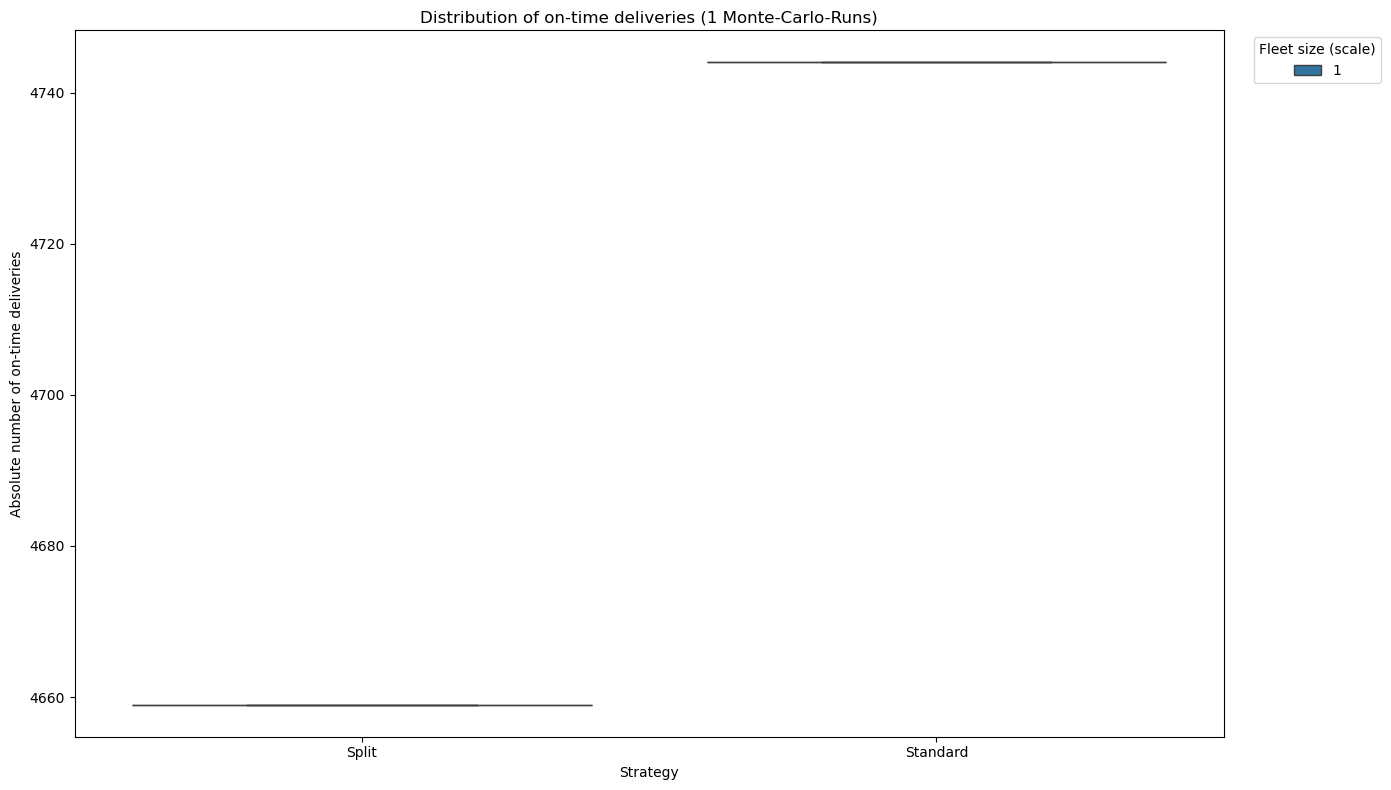

In [ ]:
num_monte_carlo_runs = 1 #10 need to be enough (Split are too many and at higher utilisation it is really slow)
all_run_results = [] #save all results

constants = {
    'initial_timestart': 1666591200, #2022-10-24 @14:00
    'SPEED_HEX_PER_STEP': 8, #count of hexgagon jump per step in workresolution
    'SPEED_FAST_HEX_PER_STEP': 9, #Speed boost, if zone is familiar
    'simulation_duration_hours': 3, #we simulate 14:00-17:00 e .g.
    'steps': 30, #duration of a single simulation timestep in seconds
    'repositioning_interval': 15 * 60, #the interval in seconds at which the repositioning strategy is triggered
    'MAX_ACCEPTABLE_DELAY_SECONDS': 5 * 60, #for assignments, to wait for better courier
    'MAX_QUEUE_ATTEMPTS': 20, #If in queue for 10 minutes -> best free courier is chosen 
    'pre_binned_demand': pre_binned_demand, # Our prediction for the three hours
    'MACRO_RESOLUTION': 8, #Hexagon resolution demand prediction and zones
    'WORK_RESOLUTION': 13 # Actors position and movement 
}

warmup_duration_seconds = 30 * 60  # 30 Minutes no metric tracking
metrics_start_time = constants['initial_timestart'] + warmup_duration_seconds

# Different phases to mark orders to be tracked and which are just for warmup
sim_data_filtered['phase'] = np.where(
    sim_data_filtered['platform_order_time'] < metrics_start_time, 
    'warmup', 
    'tracked'
)

# Use the bins defined in the second section 
jenks_bins = [-0.001, 0.164, 0.239, 0.302, 0.363, 0.421, 0.479, 0.54, 0.617, 0.741, 1.0]

# bin labels for split
bin_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Added to df
sim_data_filtered['distance_bin'] = pd.cut(sim_data_filtered['normalized_distance'],
                                           bins=jenks_bins,
                                           labels=bin_labels,
                                           include_lowest=True)

constants['SPLIT_BIN_THRESHOLD'] = 7 #determine which bin in this run
strategies = ['Split', 'Standard']
#strategies = ['Standard','Repositioning', 'Combined_Split','SPAB','Combined_SPAB'] #Strategies for run. For baseline take any name, as it is not triggering the strategies
courier_scales = [1] # determine the fleet sizes
total_active_couriers = sim_data_filtered['courier_id'].unique().shape[0] * 0.8 #determine the number of couriers

print(f"Begin with monte-carlo runs with {num_monte_carlo_runs} iteration(s)")

# See the progress
for i in tqdm(range(num_monte_carlo_runs), desc="Monte-Carlo-Run(s)"):
    current_seed = i
    single_run_data = run_monte_carlo_iteration(
        iteration_seed=current_seed, all_constants=constants,
        sim_data_df=sim_data_filtered, total_couriers=total_active_couriers,
        strategies_list=strategies, scales_list=courier_scales, rejection_m=rejection_model,blueprints = courier_blueprints, real_ids = real_ids
    )

    for params, res in single_run_data.items():
        scale, strategy = params
        total_time, metrics, total_distance = res
        delay_inc, _, success, success_delay, stacked_count, rejected_count = metrics
        all_run_results.append({
            'run_id': i, 'scale': scale, 'strategy': strategy, 'on_time_deliveries': success,
            'late_deliveries': success_delay, 'total_delivered': success + success_delay,
            'avg_delay_late': (delay_inc / success_delay) / 60 if success_delay > 0 else 0,
            'stacked_assignments': stacked_count, 'rejected_offers': rejected_count,
            'total_distance_hex': total_distance
        })

print("All monte-carlo runs done!")

results_df = pd.DataFrame(all_run_results)
#results_df.to_csv("monte_carlo_results.csv", index=False) #save the results in a dataframe
print(results_df.head())


#Boxplot for all scale and strategy combinations
plt.figure(figsize=(14, 8)) 
sns.boxplot(data=results_df, x='strategy', y='on_time_deliveries', hue='scale')
plt.title(f'Distribution of on-time deliveries ({num_monte_carlo_runs} Monte-Carlo-Runs)')
plt.xlabel('Strategy')
plt.ylabel('Absolute number of on-time deliveries')
plt.legend(title='Fleet size (scale)', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()